# Linear vs Circular, Normalized vs non-normalized correlations

In [1]:
# we should test linear vs circular to understand the differences
# the main difference in the new version was a bug as 
# the zero-padding for linear case does not work as long as you leave values on the 
# borders not zero. 
# see new normalize_intensity function that should take care of uneven illumination
# both between the frames and at different regions of the image A or B


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.registration import phase_cross_correlation
from skimage import feature
# from skimage.feature.phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from skimage.exposure import match_histograms

In [3]:
from openpiv.tools import imread
from pylab import *

In [4]:
from scipy.fft import rfft2, rfftn

In [5]:
from openpiv.pyprocess import find_subpixel_peak_position
from openpiv.pyprocess import normalize_intensity, fft_correlate_images

In [6]:
a = imread('../test11/A001_1.tif')
# b = imread('../data/PIVChallenge2001_A/A001_2.tif')
a = a[:32,:32].copy()
a[16:18,16:18] = 255
# b = b[:32,:32]

# should be in the order of y,x:
# so it's about 5 pixels upwards and about 3 pixels to the right
shift = (-12.035, -10.92)
# The shift corresponds to the pixel offset relative to the reference image
b = fourier_shift(np.fft.fftn(a), shift)
b = np.fft.ifftn(b).real
b = match_histograms(b,a).astype('uint8')
# b = b + np.linspace(10,85,32)

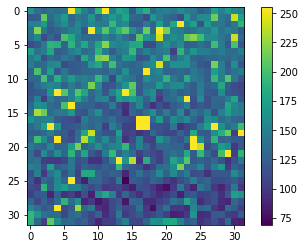

In [7]:
imshow(a)
colorbar()

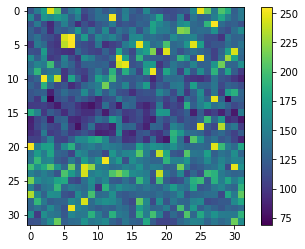

In [8]:
imshow(b)
colorbar()

In [9]:
# like moving window with the 0th dimension the IW no.
a = a[np.newaxis,:,:]
b = b[np.newaxis,:,:]

In [10]:
# %%timeit 
c1 = fft_correlate_images(a,b,'circular',normalized_correlation=False)

In [11]:
# %%timeit
c2 = fft_correlate_images(a,b,'linear',normalized_correlation=False)

In [12]:
# %%timeit
c3 = fft_correlate_images(a,b,'circular',normalized_correlation=True)

In [13]:
# %%timeit
c4 = fft_correlate_images(a,b,'linear',normalized_correlation=True)

[-12.02031891 -10.95825492] 0.05293600647141261
[ 0.03563358 -0.00205613] 22.98857744116232
[-12.0226627  -10.95144842] 0.043785720871595046
[-12.01144001 -10.94500473] 0.048564728262190826


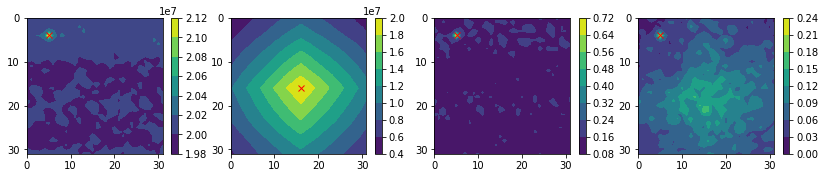

In [14]:
fig,ax = plt.subplots(1,4,figsize=(14,2.5))

counter = 0
for c in [c1,c2,c3,c4]:
    s = ax[counter].contourf(c[0,:,:])
    ax[counter].invert_yaxis()
    colorbar(s, ax=ax[counter])

    default_peak_position = np.floor(np.array(c[0,:,:].shape)/2)
    i = np.array(find_subpixel_peak_position(c[0,:,:]))
    ax[counter].plot(i[1],i[0],'rx')
    print(np.array(i - default_peak_position),
          np.sum(np.abs(np.array(i - default_peak_position)-np.array(shift))))
    counter += 1

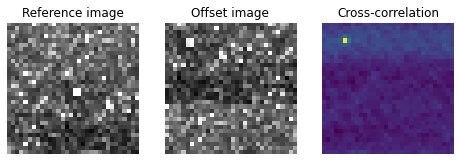

Detected pixel offset (y, x): [12. 11.]


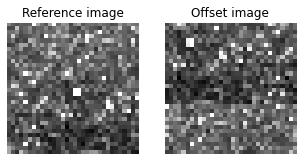

Detected subpixel offset (y, x): [-12.029 -10.932]


In [15]:
image = a[0,:,:]
offset_image = b[0,:,:]
# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image).conj() * np.fft.fft2(offset_image)
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x): {}".format(shift))

# subpixel precision
shift, error, diffphase = phase_cross_correlation(offset_image, image, upsample_factor=1000)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
# ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
# cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
# ax3.imshow(cc_image.real)
# ax3.set_axis_off()
# ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))